***Regressão Linear***

Treinar o modelo usando o knn:
    - fazer a regressão linear 
    - árvores de decisão 
    - Random Forest e variantes (e.g., XGBoost)
    - Support Vector Machines (SVM)
    - Redes Neuronais

features (x) - colunas de 0 a 11 
target (price, y) - coluna 12 

In [61]:
import pandas as pd 
import matplotlib.pyplot as plt
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
import numpy as np

In [151]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

# target = price 
# feature = everything else
# Prever o preço dos carros (Test) baseando-se no (Train)
train

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,188528,Cadillac,Escalade ESV Platinum,2017,49000,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Beige,None reported,Yes,27500
188529,188529,Mercedes-Benz,AMG C 43 AMG C 43 4MATIC,2018,28600,Gasoline,385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Black,At least 1 accident or damage reported,Yes,30000
188530,188530,Mercedes-Benz,AMG GLC 63 Base 4MATIC,2021,13650,Gasoline,469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Black,None reported,Yes,86900
188531,188531,Audi,S5 3.0T Prestige,2022,13895,Gasoline,3.0L,1-Speed Automatic,Daytona Gray Pearl Effect,Black,None reported,NaN,84900


In [152]:
# engine column splitted into horsepower, displacement, cylinders
train['horsepower'] = train['engine'].str.extract(r'(\d+\.?\d*)HP').astype(float)
train['displacement'] = train['engine'].str.extract(r'(\d+\.?\d*)L').astype(float)
train['cylinders'] = train['engine'].str.extract(r'(\d+)\s*Cylinder').astype(float)

no_engine = (train['horsepower'].isnull() & train['horsepower'].isnull() & train['horsepower'].isnull())
train['Eletric'] = np.where(no_engine, 1,0)
train.drop(columns= ['engine'], inplace=True)

# 'displacement', 'cylinders']] = train['engine'].str.split('', expand= True)

train

,id,brand,model,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,horsepower,displacement,cylinders,Eletric
0,0,MINI,Cooper S Base,2007,213000,Gasoline,A/T,Yellow,Gray,None reported,Yes,4200,172.0,1.6,4.0,0
1,1,Lincoln,LS V8,2002,143250,Gasoline,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,252.0,3.9,8.0,0
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,A/T,Blue,Gray,None reported,Yes,13900,320.0,5.3,8.0,0
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,420.0,5.0,8.0,0
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,7-Speed A/T,Black,Beige,None reported,Yes,97500,208.0,2.0,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,188528,Cadillac,Escalade ESV Platinum,2017,49000,Gasoline,Transmission w/Dual Shift Mode,White,Beige,None reported,Yes,27500,420.0,6.2,8.0,0
188529,188529,Mercedes-Benz,AMG C 43 AMG C 43 4MATIC,2018,28600,Gasoline,8-Speed A/T,White,Black,At least 1 accident or damage reported,Yes,30000,385.0,3.0,6.0,0
188530,188530,Mercedes-Benz,AMG GLC 63 Base 4MATIC,2021,13650,Gasoline,7-Speed A/T,White,Black,None reported,Yes,86900,469.0,4.0,8.0,0
188531,188531,Audi,S5 3.0T Prestige,2022,13895,Gasoline,1-Speed Automatic,Daytona Gray Pearl Effect,Black,None reported,NaN,84900,NaN,3.0,NaN,1


In [153]:
# preenche missing values e células com '–'

train = train.fillna({'fuel_type': 'unknown', 'clean_title' : 'unknown', 'accident': 'unknown', 'horsepower': 'unknown', 'displacement': 'unknown', 'cylinders': 'unknown'})

replace_cols = ['fuel_type', 'ext_col', 'int_col']

for col in replace_cols:
    train[col] = train[col].replace({'–': 'unknown'})

train


,id,brand,model,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,horsepower,displacement,cylinders,Eletric
0,0,MINI,Cooper S Base,2007,213000,Gasoline,A/T,Yellow,Gray,None reported,Yes,4200,172.0,1.6,4.0,0
1,1,Lincoln,LS V8,2002,143250,Gasoline,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,252.0,3.9,8.0,0
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,A/T,Blue,Gray,None reported,Yes,13900,320.0,5.3,8.0,0
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,420.0,5.0,8.0,0
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,7-Speed A/T,Black,Beige,None reported,Yes,97500,208.0,2.0,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,188528,Cadillac,Escalade ESV Platinum,2017,49000,Gasoline,Transmission w/Dual Shift Mode,White,Beige,None reported,Yes,27500,420.0,6.2,8.0,0
188529,188529,Mercedes-Benz,AMG C 43 AMG C 43 4MATIC,2018,28600,Gasoline,8-Speed A/T,White,Black,At least 1 accident or damage reported,Yes,30000,385.0,3.0,6.0,0
188530,188530,Mercedes-Benz,AMG GLC 63 Base 4MATIC,2021,13650,Gasoline,7-Speed A/T,White,Black,None reported,Yes,86900,469.0,4.0,8.0,0
188531,188531,Audi,S5 3.0T Prestige,2022,13895,Gasoline,1-Speed Automatic,Daytona Gray Pearl Effect,Black,None reported,unknown,84900,unknown,3.0,unknown,1


In [ ]:
# para esta coluna usamos o cat code para apenas colocar yes or no como 1 ou 0 
train['clean_title'] = train['clean_title'].astype('category')
train['clean_title'] = train['clean_title'].cat.codes


accident = {
    'None reported': 0,
    'At least 1 accident or damage reported' : 1,
}

train['accident'] = train['accident'].map(accident)

train


,id,brand,model,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,horsepower,displacement,cylinders,Eletric
0,0,MINI,Cooper S Base,2007,213000,Gasoline,A/T,Yellow,Gray,0,0,4200,172.0,1.6,4.0,0
1,1,Lincoln,LS V8,2002,143250,Gasoline,A/T,Silver,Beige,1,0,4999,252.0,3.9,8.0,0
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,A/T,Blue,Gray,0,0,13900,320.0,5.3,8.0,0
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,Transmission w/Dual Shift Mode,Black,Black,0,0,45000,420.0,5.0,8.0,0
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,7-Speed A/T,Black,Beige,0,0,97500,208.0,2.0,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,188528,Cadillac,Escalade ESV Platinum,2017,49000,Gasoline,Transmission w/Dual Shift Mode,White,Beige,0,0,27500,420.0,6.2,8.0,0
188529,188529,Mercedes-Benz,AMG C 43 AMG C 43 4MATIC,2018,28600,Gasoline,8-Speed A/T,White,Black,1,0,30000,385.0,3.0,6.0,0
188530,188530,Mercedes-Benz,AMG GLC 63 Base 4MATIC,2021,13650,Gasoline,7-Speed A/T,White,Black,0,0,86900,469.0,4.0,8.0,0
188531,188531,Audi,S5 3.0T Prestige,2022,13895,Gasoline,1-Speed Automatic,Daytona Gray Pearl Effect,Black,0,1,84900,unknown,3.0,unknown,1


In [64]:
categorical_cols = ['brand', 'model', 'engine', 'transmission', 'ext_col', 'int_col']
categorical_cols2 = ['fuel_type', 'accident', 'clean_title']
 # numeric_cols = ['id', 'model_year', 'milage']

te = TargetEncoder(cols=categorical_cols)
train[categorical_cols] = te.fit_transform(train[categorical_cols], train['price'])
test[categorical_cols] = te.transform(test[categorical_cols])

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output= False).set_output(transform='pandas')
ohetransform = ohe.fit_transform(train[categorical_cols2])

train = pd.concat([train, ohetransform], axis=1).drop(columns= train[categorical_cols2])

train


,id,brand,model,model_year,milage,engine,transmission,ext_col,int_col,price,...,fuel_type_Gasoline,fuel_type_Hybrid,fuel_type_Plug-In Hybrid,fuel_type_not supported,fuel_type_unknown,accident_At least 1 accident or damage reported,accident_None reported,accident_unkwnown,clean_title_Yes,clean_title_unknown
0,0,17162.015977,12832.716263,2007,213000,11430.680233,31711.979140,43366.336401,28182.418129,4200,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1,30712.595130,21685.985622,2002,143250,12270.346959,31711.979140,31878.405296,29953.997428,4999,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,2,41836.755127,24076.610913,2002,136731,18387.346939,31711.979140,40658.658811,28182.418129,13900,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,3,53556.327141,48913.057303,2017,19500,42265.590507,50201.815580,42417.511447,45524.117958,45000,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,4,51244.399541,64896.257198,2021,7388,37746.180897,47123.507371,42417.511447,29953.997428,97500,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,188528,45659.094780,51053.165468,2017,49000,54484.651531,50201.815580,40803.542622,29953.997428,27500,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
188529,188529,51244.399541,56181.136254,2018,28600,55884.681818,56442.748656,40803.542622,45524.117958,30000,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
188530,188530,51244.399541,63980.296474,2021,13650,73492.370933,47123.507371,40803.542622,45524.117958,86900,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
188531,188531,41004.856985,37505.533835,2022,13895,62438.239638,69596.758904,99958.609112,45524.117958,84900,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [65]:

X_train = train.drop(columns= ['price', 'id'])
Y_train = train['price']

Y_train_scaled =  np.log1p(Y_train)

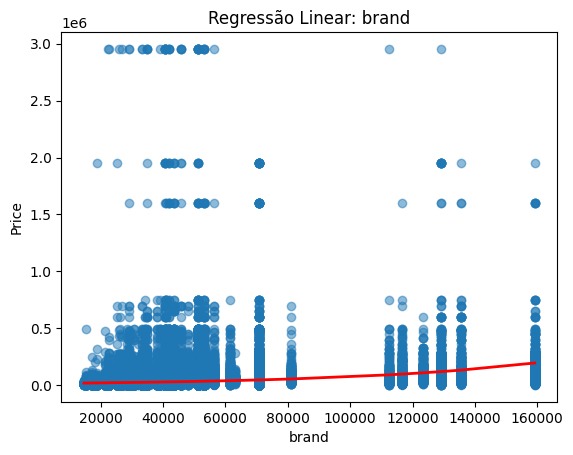

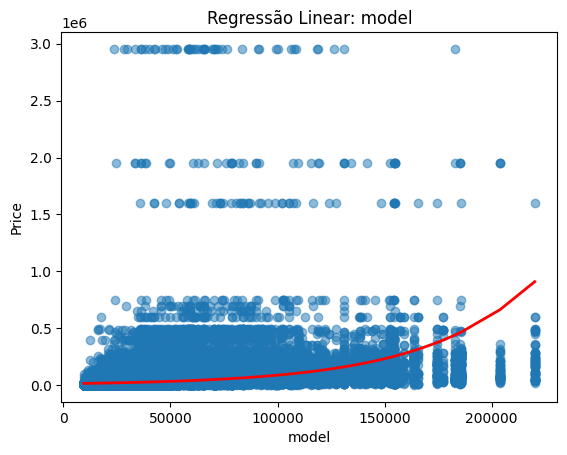

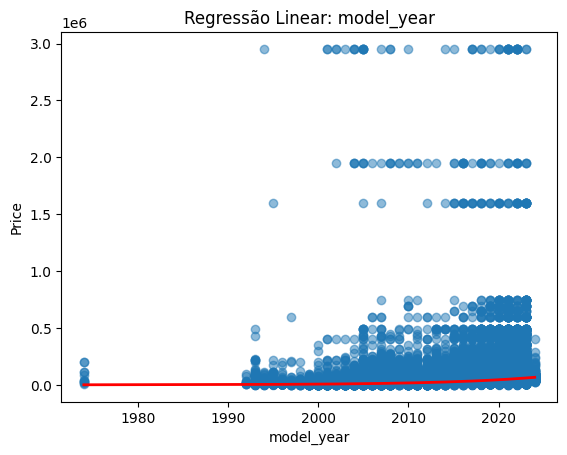

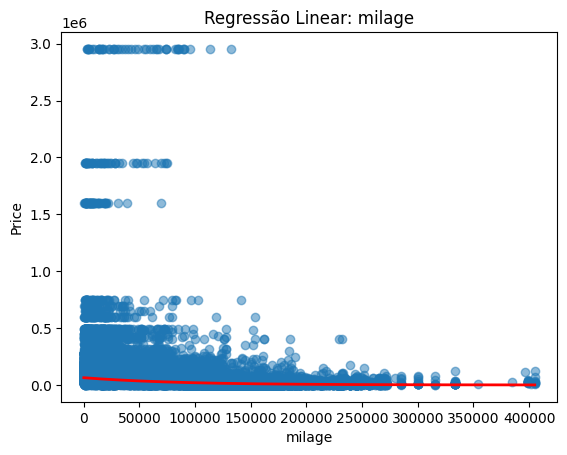

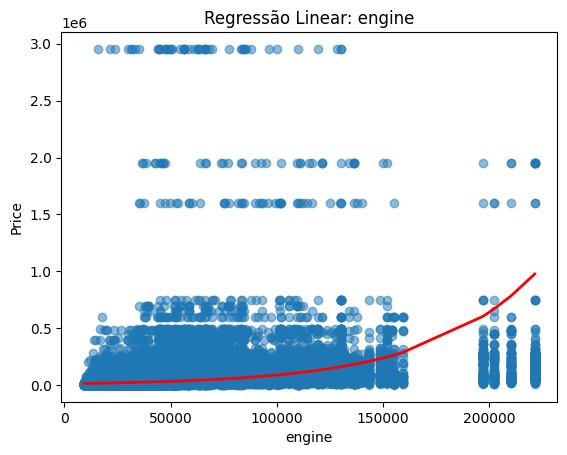

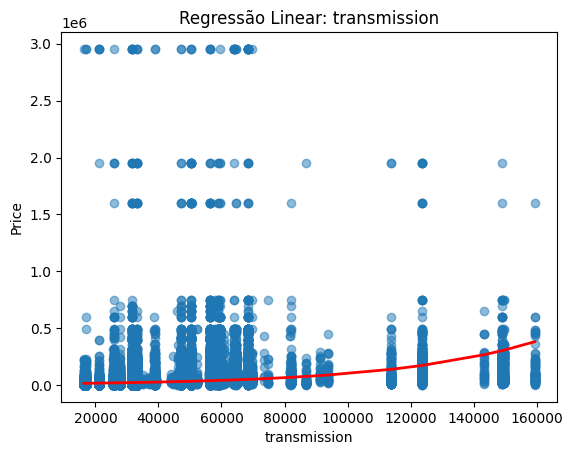

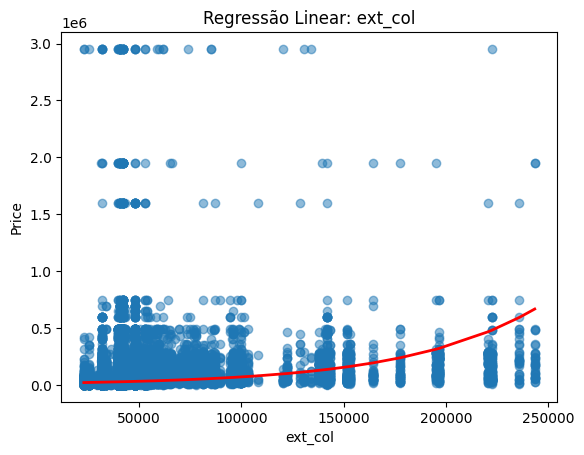

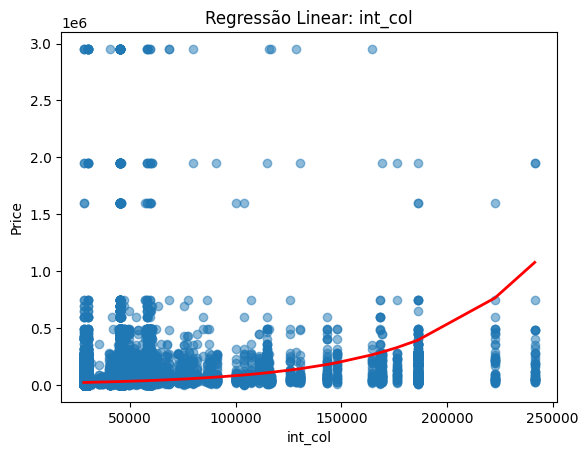

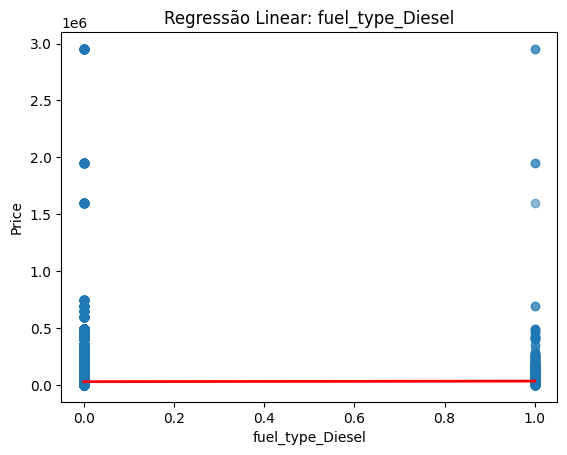

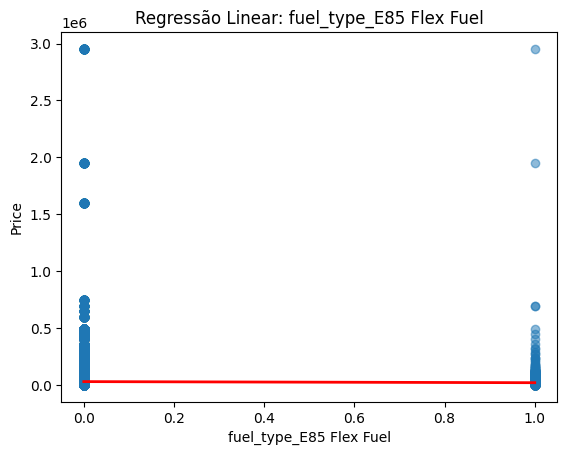

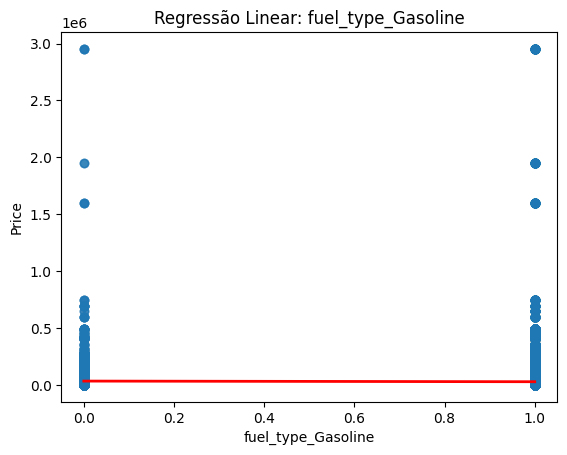

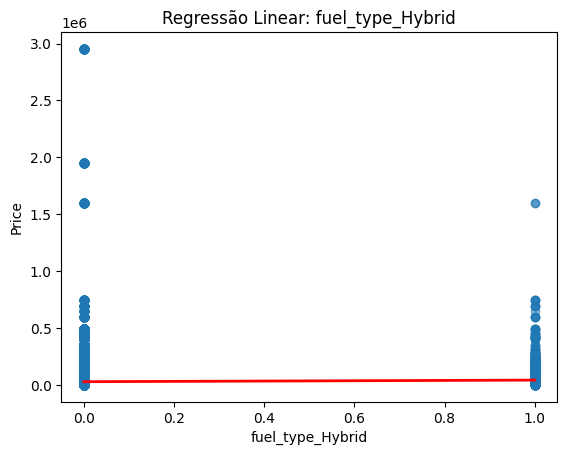

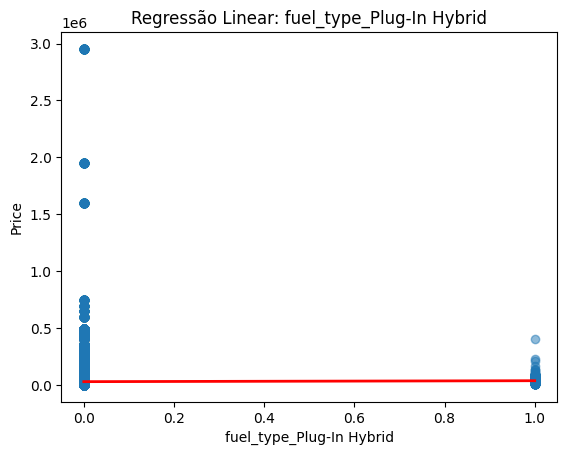

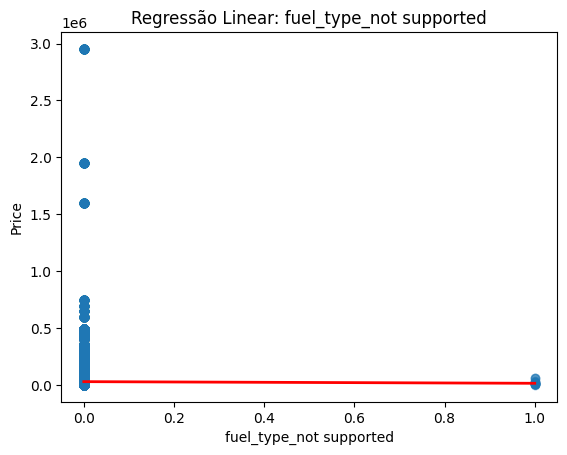

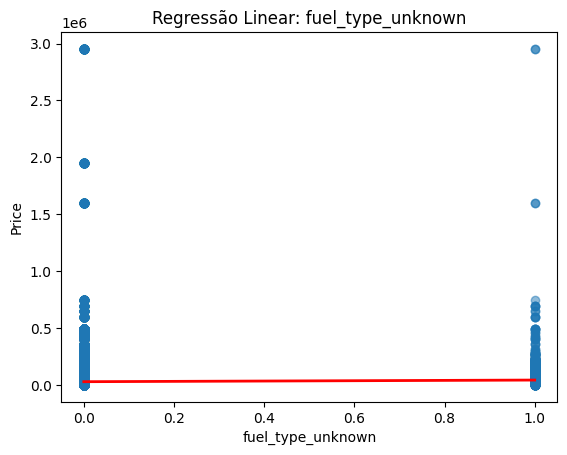

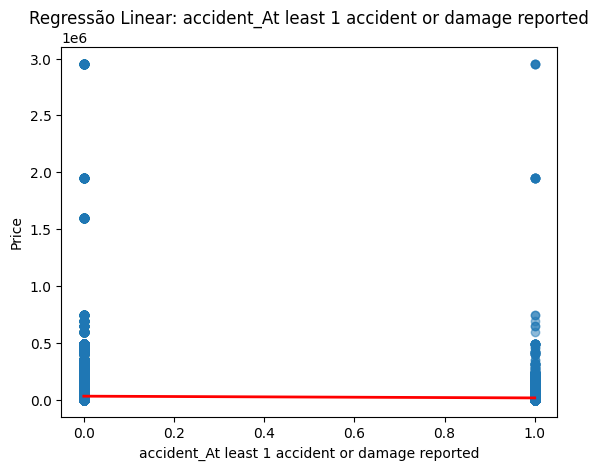

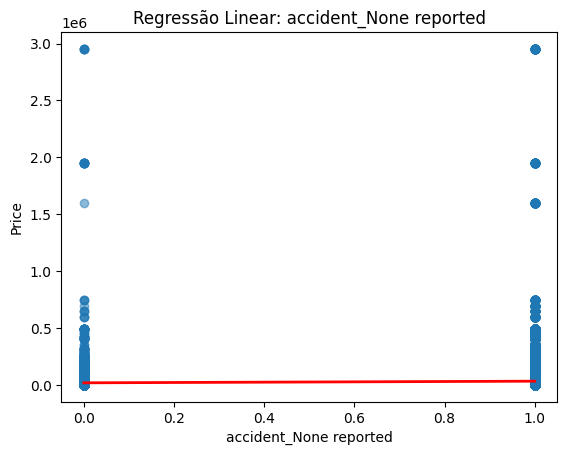

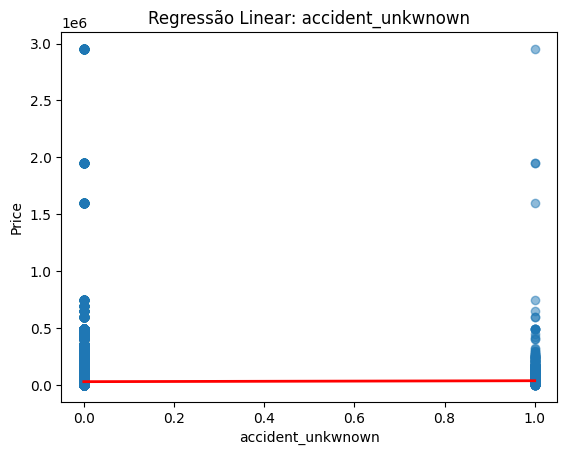

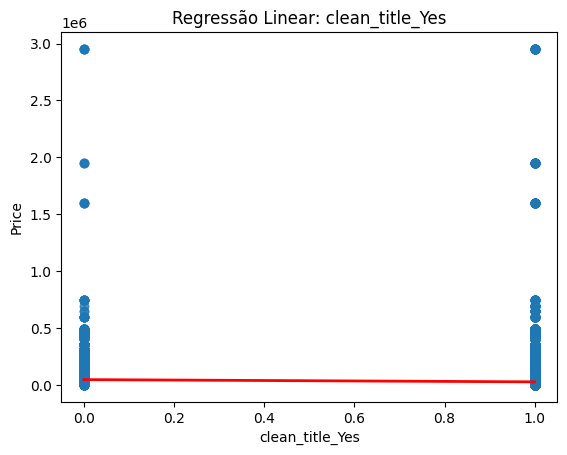

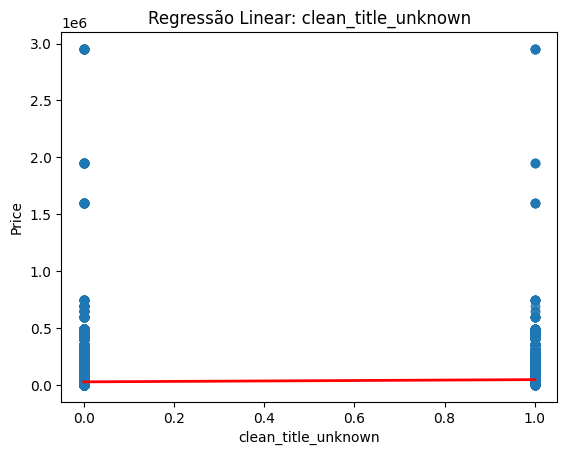

In [66]:
for k in X_train.columns:
    X_col = X_train[[k]]

    model = LinearRegression()
    model.fit(X_col, Y_train_scaled)

    y_pred_log = model.predict(X_col)
    y_pred = np.expm1(y_pred_log)   # volta para preço real

    # --- CORREÇÃO 1: ordenar antes de plotar ---
    sorted_idx = np.argsort(X_col.values.reshape(-1))
    X_sorted = X_col.values.reshape(-1)[sorted_idx]
    y_sorted = y_pred[sorted_idx]

    # --- CORREÇÃO 2: usar preço real nos pontos ---
    plt.scatter(X_col, Y_train, alpha=0.5)

    plt.plot(X_sorted, y_sorted, 'r-', linewidth=2)
    plt.xlabel(k)
    plt.ylabel("Price")
    plt.title(f"Regressão Linear: {k}")
    plt.show()

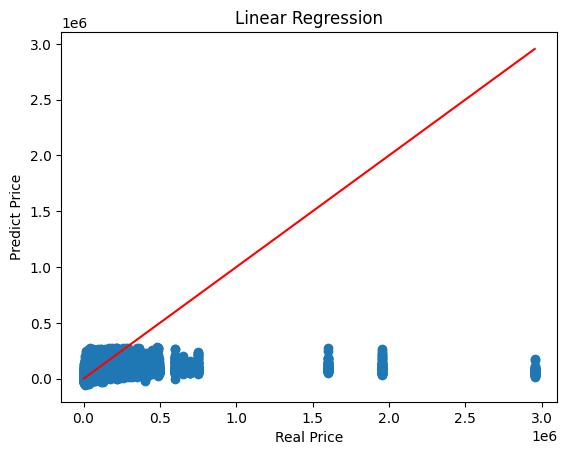

In [9]:
plt.scatter(Y_train, y_pred_train)
plt.plot([Y_train.min(),Y_train.max()], [Y_train.min(),Y_train.max()], 'r-')
plt.xlabel("Real Price")
plt.ylabel("Predict Price")
plt.title('Linear Regression')
plt.show()
